In [1]:
import sys
from glob import glob
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

from astropy.table import Table
import pandas as pd
from astropy.table import unique, join
from sklearn.preprocessing import minmax_scale

In [2]:
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, plot_uvotsource_lc, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [23]:
"""
Version 1, by Mouyuan (Eric) Sun
email: ericsun88@live.com
Version 2, by Kate Grier
email: catherine.grier@gmail.com
Version 2.1, by Mouyuan Sun
email: ericsun88@live.com
Version 2.2, by Mouyuan Sun
email: ericsun88@live.com


---------------changes of Version 2.2--------------------------------------------
Changed the centroid determination algorithm a bit (i.e., avoid using while or 
for loops; using numpy function instead)

Update the centroid calculation when sigmode=0.0 (i.e., use p value test) 

Add two data checks: 1. if the time is NOT INCREASING or 2. if the number of total 
data points < 2, the code will raise errors 

---------------end of changes of Version 2.2---------------------------------------


---------------changes of Version 2.1--------------------------------------------
Fix one bug in the xcor function. This bug is reported by Jennifer Li of UIUC; 
she found that sometimes the size of ccf12 and that of ccf21 does NOT match. 
This is an example provided by Jennifer Li

t1 = [1832., 1928., 1940., 1952., 1976., 1988., 2000.]
t2 = [1904., 1928., 1940., 1952., 1964., 1976., 1988.]

we want to calculate xcor for t1 lag t2 by 56, if we interpolate t1, no t1new 
within t2; if we interpolate t2, some data points of t2new within t1. 

My solution:
1. if imode = 1 or imode =2, the code is unchanged
2. if imode=0, let us ignore those lags in ccf12 but not in ccf21, and vice versa. 

Kate also mentioned that the sign of the time lag is in contrast with conventions. 
Therefore, I've changed the sign of the time lag by modifying:

" t2new = t1 - tau " to  "t2new = t1 + tau "

" t1new = t2 + tau " to  "t1new = t2 - tau "

---------------end of changes of Version 2.1---------------------------------------


Copyright (c) 2018 Mouyuan Sun and Catherine Grier; catherine.grier@gmail.com  

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


####################################
This code is meant to emulate a fortran program written by B. Peterson,
which cross correlates two light curves that are unevenly sampled using linear
interpolation and measure sthe peak and centroid of the cross-correlation function.
In addition, it is possible to run Monteo Carlo iterationsusing flux randomization
and random subset selection (RSS) to produce cross-correlation centroid distributions to
estimate the uncertainties in the cross correlation results.

The idea is described in detail in this work:
Peterson et al.(1998): http://arxiv.org/abs/astro-ph/9802103

The modules included are:

1. corsig: Calculates the p-value for cross-correlation (called by peakcent and xcor_mc). For
most purposes, this does not need to be used -- it is called by modules 3 and 4. 

2. xcor: Calculates the cross correlation function (called by peakcent and xcor_mc). Again does not
need to be used -- is called by the below two modules. 

**3. peakcent: Calls modues 1 and 2 to determine the peak and centroid of the cross correlation
function between two light curves, and returns the peak, centroid, CCF, r_max value,
and additional information.

**4. xcor_mc: Runs the Monte Carlo iterations using flux randomization (FR) and/or random
subset selection (RSS). Calls all of the above modules. Returns the cross correlation
centroid distribution (CCCD) and peak distribution (CCPD) of time lags as well as
information on failed calculations. 
"""

import numpy as np
import scipy.stats as sst
from matplotlib import pyplot as plt

def corsig(r, v):
    '''
    Calculate the p value that a random uncorrelated sample can yield a 
    correlation coefficient as large as or larger than the observed absolute 
    value of r, where r is the correlation coefficient of the data (using 
    t test, valid if v>=4)
    Ref1: http://janda.org/c10/Lectures/topic06/L24-significanceR.htm
    Ref2: http://vassarstats.net/textbook/ch4apx.html
    
    Inputs:
        r -- the correlation coefficient of the data
        v -- degree of freedom when calculating r: N-2 (hence N>2!!!)
    Outputs:
        pvalue
    '''
    r = float(r)
    v = float(v)
    
    r2 = r*r
    tst = r*np.sqrt(v/(1-r2))
    pvalue = sst.t.sf(tst, v) # sf: survival function -- 1-CDF
    return pvalue
    



def xcor(t1, y1, t2, y2, tlagmin, tlagmax, tunit, imode=0):
    '''
    Calculate cross-correlation function for unevenly 
    sampling data.
    
    Inputs:
        t1 -- time for light curve 1, assume increase;
        y1 -- flux for light curve 1;
        t2 -- time for light curve 2, assume increase;
        y2 -- flux for light curve 2;
        tlagmin -- minimum time lag;
        tlagmax -- maximum time lag;
        tunit -- tau step;
        imode -- cross-correlation mode: 0, twice (default); 
                 1, interpolate light curve 1;
                 2, interpolate light curve 2.
        
    Outputs:
        ccf -- correlation coefficient;
        tlag -- time lag (t2 - t1); positive values mean second
                  light curve lags the first light curve, as per convention.
                 (edit by kate, march 2016)
        npts -- number of data points used;
    '''
    if np.sum(np.diff(t1)<0.0)>0 or np.sum(np.diff(t2)<0.0)>0:
        raise Exception("The time of light curve 1 or light curve 2 is NOT INCREASING!!! Please check your data!!!")
    n1 = len(y1)
    n2 = len(y2)
    if n1<2 or n2<2:
        raise Exception("The light curve should contain at least 2 data points!!!")
    safe = tunit*0.1
    taulist12 = []
    taulist21 = []
    npts12 = []
    npts21 = []
    ccf12 = []  # interpolate 2
    ccf21 = []  # interpolate 1
    tau_max = tlagmax+safe
    # first interpolate 2
    if imode != 1:
        tau = tlagmin + 0.0 # if imode=1, skip the interpolate 2 step
    else:
        tau = tau_max + 0.0
    while tau < tau_max:
        t2new = t1 + tau
        selin = np.where((t2new>=np.min(t2))&(t2new<=np.max(t2)), True, False)
        knot = np.sum(selin)  # number of datapoints used
        if knot>0:
            y2new = np.interp(t2new[selin], t2, y2)
            
            y1sum = np.sum(y1[selin])
            y1sqsum = np.sum(y1[selin]*y1[selin])
            y2sum = np.sum(y2new)
            y2sqsum = np.sum(y2new*y2new)
            y1y2sum = np.sum(y1[selin]*y2new)
            
            fn = float(knot)
            rd1_sq = fn*y2sqsum - y2sum*y2sum
            rd2_sq = fn*y1sqsum - y1sum*y1sum
            if rd1_sq>0.0:
                rd1 = np.sqrt(rd1_sq)
            else:
                rd1 = 0.0
            if rd2_sq>0.0:
                rd2 = np.sqrt(rd2_sq)
            else:
                rd2 = 0.0
            
            if rd1*rd2==0.0:
                r = 0.0
            else:
                r = (fn*y1y2sum - y2sum*y1sum)/(rd1*rd2)
            ccf12.append(r)
            taulist12.append(tau)
            npts12.append(knot)
        tau += tunit
    # now interpolate 1
    if imode != 2:
        tau = tlagmin + 0.0
    else:
        tau = tau_max + 0.0
    while tau < tau_max:
        t1new = t2 - tau
        selin = np.where((t1new>=np.min(t1))&(t1new<=np.max(t1)), True, False)
        knot = np.sum(selin)  # number of datapoints used
        if knot>0:
            y1new = np.interp(t1new[selin], t1, y1)
            
            y2sum = np.sum(y2[selin])
            y2sqsum = np.sum(y2[selin]*y2[selin])
            y1sum = np.sum(y1new)
            y1sqsum = np.sum(y1new*y1new)
            y1y2sum = np.sum(y1new*y2[selin])
            
            fn = float(knot)
            rd1_sq = fn*y2sqsum - y2sum*y2sum
            rd2_sq = fn*y1sqsum - y1sum*y1sum
            if rd1_sq>0.0:
                rd1 = np.sqrt(rd1_sq)
            else:
                rd1 = 0.0
            if rd2_sq>0.0:
                rd2 = np.sqrt(rd2_sq)
            else:
                rd2 = 0.0
            
            if rd1*rd2==0.0:
                r = 0.0
            else:
                r = (fn*y1y2sum - y2sum*y1sum)/(rd1*rd2)
            ccf21.append(r)
            taulist21.append(tau)
            npts21.append(knot)
        tau += tunit
    
    # return results according to imode
    taulist12 = np.asarray(taulist12)
    npts12 = np.asarray(npts12)
    taulist21 = np.asarray(taulist21)
    npts21 = np.asarray(npts21)
    ccf12 = np.asarray(ccf12)
    ccf21 = np.asarray(ccf21)
    if imode==0:
        # make sure taulist12 and taulist21 have the same size!!!
        if np.array_equal(taulist12, taulist21):
            ccf = (ccf12 + ccf21)*0.5
            taulist = taulist12 + 0.0
            npts = npts12 + 0.0
        else:
            taulist = np.intersect1d(taulist12, taulist21)
            sel_cb12 = np.in1d(taulist12, taulist)
            sel_cb21 = np.in1d(taulist21, taulist)
            ccf = (ccf12[sel_cb12] + ccf21[sel_cb21])*0.5
            npts = (npts12[sel_cb12] + npts21[sel_cb21])*0.5
    elif imode==1:
        ccf = ccf21 + 0.0
        taulist = taulist21 + 0.0
        npts = npts21 + 0.0
    else:
        ccf = ccf12 + 0.0
        taulist = taulist12 + 0.0
        npts = npts12 + 0.0
    
    return ccf, taulist, npts




def peakcent(t1, y1, t2, y2, tlagmin, tlagmax, tunit, thres=0.8, siglevel=0.95, imode=0, sigmode = 0.2):
    '''
    Calculate peak time lag and centroid based on the cross-correlation 
    function for unevenly sampling data.
    
    Inputs:
        t1 -- time for light curve 1, assume increase;
        y1 -- flux for light curve 1;
        t2 -- time for light curve 2, assume increase;
        y2 -- flux for light curve 2;
        tlagmin -- minimum time lag;
        tlagmax -- maximum time lag;
        tunit -- tau step;
        thres -- lower limit of correlation coefficient when 
                 calculate centroid, default is 0.8;
        siglevel -- the required significant level of the 
                 correlation coefficient;
        imode -- cross-correlation mode: 0, twice (default); 
                 1, interpolate light curve 1;
                 2, interpolate light curve 2.
        sigmode -- how to deal with significance:
                Will use r = input value as the minimum correlation coefficient to consider (default = 0.2).
                0: Will use a p-test to assign significance to peak and discard peaks that are below
                the significance threshold (depends on number of points included and r). 
        
    Outputs:
        tlag_peak -- time lag based on the peak argument;
        status_peak -- peak status (1, constrained; 0, unconstrained);
        tlag_centroid -- time lag for centroid;
        status_centroid -- centroid status (1, constrained; 0, unconstrained);
    '''
    alpha = 1.0 - siglevel  # probability threshold to reject: no correlation hypothesis
    
    ccf_pack = xcor(t1, y1, t2, y2, tlagmin, tlagmax, tunit, imode)
    max_indx = np.argmax(ccf_pack[0])
    max_rval = ccf_pack[0][max_indx]
    if ccf_pack[2][max_indx]>2.0:
        peak_pvalue = corsig(ccf_pack[0][max_indx]-0.0001, float(ccf_pack[2][max_indx]-2.0))#
    else:
        peak_pvalue = 1.0 # significance level
    # ccf peaks --- excluding all with r < 0.2 instead of using p-value test. 
    if sigmode > 0:
        #print 'Using minimum r coefficient instead of significance test.'        
        #Check and see if the max r is on the edge of the CCF. Fail it if so. 
        if max_rval >= sigmode and ccf_pack[1][max_indx] > tlagmin and ccf_pack[1][max_indx] < tlagmax: 
            tlag_peak = ccf_pack[1][max_indx]
            max_rval = max_rval
            status_peak = 1
            status_rval = 1
            status_centroid = 0 # if lag is well determined, we will change status_centroid to 1
            tlag_centroid = -9999.0
        else:
            max_rval = -9999.0
            tlag_peak = -9999.0
            tlag_centroid = -9999.0
            status_peak = 0
            status_rval = 0
            status_centroid = 0
    else:
        # ccf peaks-- Eric's method using a p-value test (usually not using) 
        #Check and see if the max r is on the edge of the CCF. Fail it if so. 
        if peak_pvalue<alpha and ccf_pack[1][max_indx] > tlagmin and ccf_pack[1][max_indx] < tlagmax:
            tlag_peak = ccf_pack[1][max_indx]
            max_rval = max_rval
            status_peak = 1
            status_rval = 1
            status_centroid = 0 # if lag is well determined, we will change status_centroid to 1
            tlag_centroid = -9999.0
        else:
            max_rval = -9999.0
            tlag_peak = -9999.0
            tlag_centroid = -9999.0
            status_peak = 0
            status_rval = 0
            status_centroid = 0
    #If the peak succeeds, calculate centroid:
    if status_peak == 1:
        rcent = thres*max_rval
        # find out the range of centroid around the primary peak
        rdif_neg = np.where(ccf_pack[0]-rcent<0.0, True, False)

        tlag_rneg = ccf_pack[1][rdif_neg] - tlag_peak
        tlag_leftall = np.abs(tlag_rneg[tlag_rneg<0.0])
        tlag_rightall = np.abs(tlag_rneg[tlag_rneg>0.0])
        if len(tlag_leftall)>0 and len(tlag_rightall)>0:
            rdif_pos = np.where(ccf_pack[0]-rcent>=0.0, True, False) 
            if np.sum(rdif_pos)>0:
                tlag_centroid = np.sum(ccf_pack[0][rdif_pos]*ccf_pack[1][rdif_pos])/np.sum(ccf_pack[0][rdif_pos])
                status_centroid = 1    
    # end of centroid calculation
    #Now, if the centroid fails, re-set the peak status to 0 because we don't want to report a peak without a centroid!
    if status_centroid == 0:
        status_peak = 0
        tlag_peak = -9999.0
        max_rval = -9999.0
        status_rval = 0 
    #print tlag_peak, status_peak, tlag_centroid, status_centroid, max_rval, status_rval
    return tlag_peak, status_peak, tlag_centroid, status_centroid, ccf_pack, max_rval, status_rval, peak_pvalue




def xcor_mc(t1, y1, dy1, t2, y2, dy2, tlagmin, tlagmax, tunit, thres=0.8, siglevel=0.95, imode=0, nsim=2048, mcmode=0, sigmode = 0.2):
    '''
    Calculate the uncertainty for the cross-correlation peak.
    
    Inputs:
        t1 -- time for light curve 1, assume increase;
        y1 -- flux for light curve 1;
        dy1 -- flux uncertainty for light curve 1;
        t2 -- time for light curve 2, assume increase;
        y2 -- flux for light curve 2;
        dy2 -- flux uncertainty for light curve 2;
        tlagmin -- minimum time lag;
        tlagmax -- maximum time lag;
        tunit -- tau step;
        thres -- lower limit of correlation coefficient when 
                 calculate centroid, default is 0.8;
        siglevel -- the required significant level of the 
                 correlation coefficient;
        imode -- cross-correlation mode: 0, twice (default); 
                 1, interpolate light curve 1;
                 2, interpolate light curve 2.
        nsim -- MC simulation trials;
        mcmode -- MC mode: 0, RSS plus FR
                  1, RSS only
                  2, FR only
        sigmode -- How to exclude non-significant peaks:
                  Will exclude all peaks with r < input value 
                  0 will exclude all peaks based on p-value significance test. 
        
    Outputs:
        tlags_peak -- tlag of peak distribution;
        tlags_centroid -- tlag of centroid distribution;
        nsuccess_peak -- success times in finding peaks;
        nfail_peak -- fail times in finding peaks;
        nsuccess_centroid -- success times in calculating centroid;
        nfail_centroid -- fail times in calculating centroid.
    '''
    if np.sum(np.diff(t1)<0.0)>0 or np.sum(np.diff(t2)<0.0)>0:
        raise Exception("The time of light curve 1 or light curve 2 is NOT INCREASING!!! Please check your data!!!")
    numt1 = len(t1)
    numt2 = len(t2)
    if numt1<2 or numt2<2:
        raise Exception("The light curve should contain at least 2 data points!!!")
    tlags_peak = []
    tlags_centroid = []
    pvals = []
    nsuccess_peak = 0
    nsuccess_rvals = 0
    nfail_peak = 0
    nsuccess_centroid = 0
    nfail_centroid = 0
    nfail_rvals = 0
    max_rvals = []
    for i in range(nsim):
        if mcmode!=2:
            # RSS resample light curve 1
            mycheck = True #make sure len(t1_rss)>1
            while mycheck:
                indx1 = np.random.randint(0, numt1, numt1)
                unique1, counts1 = np.unique(indx1, return_counts=True) # sorted unique value
                t1_rss = t1[unique1]
                y1_rss = y1[unique1]
                dy1_rss = dy1[unique1]/np.sqrt(counts1)
                if len(t1_rss)>1:
                    # keep running unless len(t1_rss)>1
                    mycheck = False
            # RSS resample light curve 2
            mycheck = True #make sure len(t2_rss)>1
            while mycheck:
                indx2 = np.random.randint(0, numt2, numt2)
                unique2, counts2 = np.unique(indx2, return_counts=True)
                t2_rss = t2[unique2]
                y2_rss = y2[unique2]
                dy2_rss = dy2[unique2]/np.sqrt(counts2)
                if len(t2_rss)>1:
                    # keep running unless len(t2_rss)>1
                    mycheck = False
            
        else:
            # do not apply RSS resample, rss light curve equals to original one
            t1_rss = t1 + 0.0
            y1_rss = y1 + 0.0
            dy1_rss = dy1 + 0.0
            
            t2_rss = t2 + 0.0
            y2_rss = y2 + 0.0
            dy2_rss = dy2 + 0.0
            
        
        if mcmode!=1:
            # measurement error perturbation
            t1_fr = t1_rss + 0.0
            y1_fr = np.random.normal(y1_rss, dy1_rss)
            t2_fr = t2_rss + 0.0
            y2_fr = np.random.normal(y2_rss, dy2_rss)
        else:
            # do not aplly the error perturbation
            t1_fr = t1_rss + 0.0
            y1_fr = y1_rss + 0.0
            t2_fr = t2_rss + 0.0
            y2_fr = y2_rss + 0.0
        
        # perform CCF
        pc_pack = peakcent(t1_fr, y1_fr, t2_fr, y2_fr, tlagmin, tlagmax, tunit, thres, siglevel, imode, sigmode = sigmode)
        
        # ccf peaks
        if pc_pack[1]==1:
            tau_peak = pc_pack[0]
            tlags_peak.append(tau_peak)
            pval = pc_pack[7]
            pvals.append(pval)
            nsuccess_peak += 1
        elif pc_pack[1] == 0:
            nfail_peak += 1
        
        # ccf centroids
        if pc_pack[3]==1:
            tau_centroid = pc_pack[2]
            tlags_centroid.append(tau_centroid)
            nsuccess_centroid += 1
        else:
            nfail_centroid += 1
            
        # max_rvalues
        if pc_pack[6]==1:
            max_rvals.append(pc_pack[5])
            nsuccess_rvals += 1
        else:
            nfail_rvals += 1

    
    tlags_peak = np.asarray(tlags_peak)
    tlags_centroid = np.asarray(tlags_centroid)
    print('Failed centroids: ', nfail_centroid)
    print('Failed peaks: ', nfail_peak)
    
    return tlags_peak, tlags_centroid, nsuccess_peak, nfail_peak, nsuccess_centroid, nfail_centroid, max_rvals, nfail_rvals, pvals


In [24]:
simbad_name = 'NAME_NGC_1313_X-2'

local_name  = source_names_dict[simbad_name]
readable_name = source_names_readable[simbad_name]

uvot_filter = 'U'
xrt_curve = 'HARD'

xrt_rate      = 'RATE'
xrt_rate_err  = 'RATE_ERR'

uvot_rate     = 'RAW_TOT_RATE'
uvot_rate_err = 'RAW_TOT_RATE_ERR'

# Load X-ray Data
tab_xrt_full = load_xrt(simbad_name=simbad_name, curve=xrt_curve, pandas=False)
tab_xrt_full = rename_xrt_cols(tab_xrt_full)

# Load UV Data
tab_uvot = read_uvotsource(f'../download_scripts/NGC1313/X-2_src_uvotsource_all.fits')
tab_uvot = tab_uvot[tab_uvot['FILTER'] == uvot_filter]
tab_uvot = unique(tab_uvot, keys='OBSID')

# Join Data
tab_join = join(tab_uvot, tab_xrt_full , join_type='inner', keys='OBSID')
tab_join.sort('MJD_0')

Loading XRT...
simbad_name=NAME_NGC_1313_X-2 curve=HARD pandas=False
Loading file: /mnt/d/anticorr_data/UKSSDC/NAME_NGC_1313_X-2/USERPROD_45605/lc/hardrat_HARD_PC.csv
df shape=(452, 6) unique_obs=452
Reading uvotsource...
Reading file ../download_scripts/NGC1313/X-2_src_uvotsource_all.fits
tab len=538 unique_obs=485
UVOT flag summary:
FLAG_AB_MAG_99      = 15 / 538 (2.79%)
FLAG_UPPER_LIM      = 23 / 538 (4.28%)
FLAG_AB_MAG_ERR>2   = 15 / 538 (2.79%)
FLAG_AB_MAG_>10_<30 = 15 / 538 (2.79%)


In [25]:
tab_join

MET,EXTNAME,TSTART,TSTOP,EXPOSURE,TELAPSE,TIME,SRC_AREA,BKG_AREA,STD_AREA,PLATE_SCALE,RAW_TOT_CNTS,RAW_TOT_CNTS_ERR,RAW_BKG_CNTS,RAW_BKG_CNTS_ERR,RAW_STD_CNTS,RAW_STD_CNTS_ERR,RAW_TOT_RATE,RAW_TOT_RATE_ERR,RAW_BKG_RATE,RAW_BKG_RATE_ERR,RAW_STD_RATE,RAW_STD_RATE_ERR,COI_STD_FACTOR,COI_STD_FACTOR_ERR,COI_BKG_FACTOR,COI_BKG_FACTOR_ERR,COI_TOT_RATE,COI_TOT_RATE_ERR,COI_BKG_RATE,COI_BKG_RATE_ERR,COI_SRC_RATE,COI_SRC_RATE_ERR,AP_FACTOR,AP_FACTOR_ERR,AP_COI_SRC_RATE,AP_COI_SRC_RATE_ERR,LSS_FACTOR,LSS_RATE,LSS_RATE_ERR,SENSCORR_FACTOR,SENSCORR_RATE,SENSCORR_RATE_ERR,CORR_RATE,CORR_RATE_ERR,AB_MAG,AB_MAG_ERR,AB_MAG_ERR_STAT,AB_MAG_ERR_SYS,AB_MAG_BKG,AB_MAG_BKG_ERR_STAT,AB_MAG_BKG_ERR_SYS,AB_MAG_BKG_ERR,AB_MAG_LIM,AB_MAG_LIM_SIG,AB_MAG_COI_LIM,AB_FLUX_AA,AB_FLUX_AA_ERR_STAT,AB_FLUX_AA_ERR_SYS,AB_FLUX_AA_ERR,AB_FLUX_AA_BKG,AB_FLUX_AA_BKG_ERR_STAT,AB_FLUX_AA_BKG_ERR_SYS,AB_FLUX_AA_BKG_ERR,AB_FLUX_AA_LIM,AB_FLUX_AA_COI_LIM,AB_FLUX_HZ,AB_FLUX_HZ_ERR_STAT,AB_FLUX_HZ_ERR_SYS,AB_FLUX_HZ_ERR,AB_FLUX_HZ_BKG,AB_FLUX_HZ_BKG_ERR_STAT,AB_FLUX_HZ_BKG_ERR_SYS,AB_FLUX_HZ_BKG_ERR,AB_FLUX_HZ_LIM,AB_FLUX_HZ_COI_LIM,MAG,MAG_ERR,MAG_ERR_STAT,MAG_ERR_SYS,MAG_BKG,MAG_BKG_ERR_STAT,MAG_BKG_ERR_SYS,MAG_BKG_ERR,MAG_LIM,MAG_LIM_SIG,MAG_COI_LIM,FLUX_AA,FLUX_AA_ERR_STAT,FLUX_AA_ERR_SYS,FLUX_AA_ERR,FLUX_AA_BKG,FLUX_AA_BKG_ERR_STAT,FLUX_AA_BKG_ERR_SYS,FLUX_AA_BKG_ERR,FLUX_AA_LIM,FLUX_AA_COI_LIM,FLUX_HZ,FLUX_HZ_ERR_STAT,FLUX_HZ_ERR_SYS,FLUX_HZ_ERR,FLUX_HZ_BKG,FLUX_HZ_BKG_ERR_STAT,FLUX_HZ_BKG_ERR_SYS,FLUX_HZ_BKG_ERR,FLUX_HZ_LIM,FLUX_HZ_COI_LIM,COI_RATE_LIMIT,CORR_RATE_LIMIT,FILTER,RA,DEC,DETX,DETY,NSIGMA,FRAMTIME,SATURATED,SYS_ERR,SRCEXP,BKGEXP,OBSID,MJD_1,YEAR,MJD_0,FLAG_AB_MAG_99,FLAG_UPPER_LIM,FLAG_AB_MAG_ERR>2,FLAG_AB_MAG_>10_<30,MJD_2,MJD_ERR_POS,MJD_ERR_NEG,RATE,RATE_ERR
s,,s,s,s,s,s,arcsec2,arcsec2,arcsec2,arcsec / pix,ct,ct,ct,ct,ct,ct,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,,,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,ct / s,ct / s,,ct / s,ct / s,,ct / s,ct / s,ct / s,ct / s,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,ct / s,ct / s,,deg,deg,pix,pix,,s,,,s,s,,s,,s,,,,,,,,,
float64,bytes12,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float64,float64,float32,float32,float32,float32,int16,bool,float32,float32,str11,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,float64,float64
172587267.65609,U,172549649.16682,172624886.14536,655.1939,75236.98,0.0,78.467995,706.79254,78.467995,1.004,1158.201,33.704155,7365.411,85.22705,1158.201,33.704155,1.7677225,0.05144

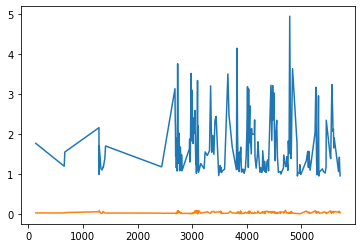

In [26]:
plt.plot(tab_join['MJD_0'], tab_join['RAW_TOT_RATE'])
plt.plot(tab_join['MJD_0'], tab_join['RATE'])


In [27]:
from sklearn.preprocessing import minmax_scale

In [28]:
tlag_peak, status_peak, tlag_centroid, status_centroid, ccf_pack, max_rval, status_rval, peak_pvalue = peakcent(
         t1=tab_join['MJD_0'],
         y1=minmax_scale(tab_join['RAW_TOT_RATE']),
         t2=tab_join['MJD_0'],
         y2=minmax_scale(tab_join['RATE']),
         tlagmin=10,
         tlagmax=1000,
         tunit=1.0,
         thres=0.8,
         siglevel=0.95,
         imode=0,
         sigmode = 0.2)

In [29]:
print(tlag_peak)
print(status_peak)
print(tlag_centroid)
print(status_centroid)
print(ccf_pack)
print(max_rval)
print(status_rval)
print(peak_pvalue)

-9999.0
0
-9999.0
0
(array([ 1.06946394e-01,  1.10967807e-01,  1.15596901e-01,  1.15464659e-01,
        1.09989897e-01,  1.06073576e-01,  1.08305634e-01,  1.23126228e-01,
        1.20531055e-01,  1.17344685e-01,  1.09607782e-01,  9.70300832e-02,
        8.16776253e-02,  6.21775237e-02,  5.28799911e-02,  6.63003310e-02,
        6.90660012e-02,  6.87835163e-02,  7.50201186e-02,  7.43074843e-02,
        7.24320593e-02,  6.84401860e-02,  5.89477343e-02,  5.54909645e-02,
        5.17541431e-02,  4.80382305e-02,  4.17788539e-02,  3.50391241e-02,
        2.81767364e-02,  2.62538541e-02,  2.49246569e-02,  2.34890606e-02,
        2.12990290e-02,  1.21496964e-02,  7.26588101e-03,  3.42497175e-03,
        6.77303499e-03,  1.11752312e-02,  1.68930793e-02,  1.24380943e-02,
        1.68975409e-02,  2.06689517e-02,  2.86440300e-02,  2.66693189e-02,
        4.74494145e-02,  7.34583684e-02,  9.33885605e-02,  1.00613556e-01,
        1.07015500e-01,  1.12641221e-01,  1.15162712e-01,  1.14115816e-01,
    

[]

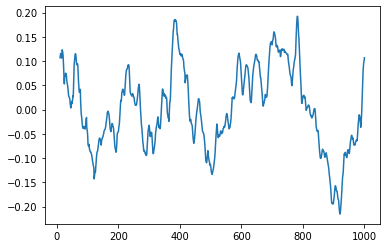

In [40]:
plt.plot(ccf_pack[1], ccf_pack[0])
plt.plot()

In [37]:
tlags_peak, tlags_centroid, nsuccess_peak, nfail_peak, nsuccess_centroid, nfail_centroid, max_rvals, nfail_rvals, pvals = xcor_mc(t1=tab_join['MJD_0'],
                                                                                                                                  y1=tab_join['RAW_TOT_RATE'],
                                                                                                                                  dy1=tab_join['RAW_TOT_RATE_ERR'],
                                                                                                                                  t2=tab_join['MJD_0'],
                                                                                                                                  y2=tab_join['RATE'],
                                                                                                                                  dy2=tab_join['RATE_ERR'],
                                                                                                                                  tlagmin=1,
                                                                                                                                  tlagmax=100,
                                                                                                                                  tunit=1,
                                                                                                                                  thres=0.8,
                                                                                                                                  siglevel=0.95,
                                                                                                                                  imode=0,
                                                                                                                                  nsim=100,
                                                                                                                                  mcmode=0,
                                                                                                                                  sigmode = 0.2)

Failed centroids:  87
Failed peaks:  87


In [39]:
print(tlags_peak)
print(tlags_centroid)
print(nsuccess_peak)
print(nfail_peak)
print(nsuccess_centroid)
print(nfail_centroid)
print(max_rvals)
print(nfail_rvals)
print(pvals)

[17. 31. 75. 61. 55. 12. 56. 68. 48. 19. 56. 17. 60.]
[17.06425505 42.54003428 72.13627362 61.93107637 42.13955952 14.39492518
 51.01397129 66.99001565 49.3795757  17.14450283 57.5278946  17.13823041
 60.90992146]
13
87
13
87
[0.23784641322467565, 0.22422224905812488, 0.2434563694446234, 0.2454514177775765, 0.20283898349783117, 0.25348277884326775, 0.21963129837208312, 0.21316906007853603, 0.23437948329855024, 0.20489838044804518, 0.25924972352107334, 0.21435073915208427, 0.2157425931904517]
87
[0.0017523716938356601, 0.004113641182706301, 0.0017597365567176059, 0.0013252875854739361, 0.00854416452931837, 0.0008783544580548162, 0.004332474859482023, 0.0050395715456885565, 0.002354485503965159, 0.007245500219232604, 0.0007351657263298939, 0.004463868941747149, 0.004473762879019478]
